In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from io import StringIO
import sys
import time
import csv
import logging
import os
from shapely import wkb, wkt
from shapely.geometry import Point
import traceback
from pywtk.site_lookup import get_3tiersites_from_wkt

In [46]:
min_lng = -102
max_lng = -94
min_lat = 37
max_lat = 40
wkt = "POLYGON(({0} {3},{1} {3},{1} {2},{0} {2},{0} {3}))".format(min_lng, max_lng, min_lat, max_lat)

In [3]:
# get sites 
site_df = get_3tiersites_from_wkt(wkt)

In [4]:
print(site_df.columns)
site_df = site_df.reset_index()
print(site_df.columns)

Index(['gid', 'fraction_of_usable_area', 'power_curve', 'capacity',
       'wind_speed', 'capacity_factor', 'the_geom', 'city', 'state', 'country',
       'elevation', 'point', 'lat', 'lon'],
      dtype='object')
Index(['site_id', 'gid', 'fraction_of_usable_area', 'power_curve', 'capacity',
       'wind_speed', 'capacity_factor', 'the_geom', 'city', 'state', 'country',
       'elevation', 'point', 'lat', 'lon'],
      dtype='object')


In [5]:
# create csv
site_df[['site_id', 'lat', 'lon', 'capacity', 'capacity_factor']].to_csv('interesting_sites.csv', index=False)

In [7]:
# save csv to sites.csv
# !head kansas_sites.csv

head: kansas_sites.csv: No such file or directory


In [10]:
sites = site_df[['site_id','state','point','lat','lon']].copy()

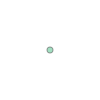

In [21]:
sites[['point']].iloc[1].values[0]

In [38]:
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
attributes = ['windspeed_10m', 'windspeed_100m', 'temperature_10m', 'temperature_100m', 'winddirection_100m']
url = 'https://developer.nrel.gov/api/wind-toolkit/v2/wind/wtk-download.csv?'
parameters = { 'api_key' : 'yMDVMKtCa4FGh2vmvstXY8ZDZbWKqBl2vddmnKZg', 
              'wkt' : sites[['point']].iloc[1].values[0],
             'attributes' : ['windspeed_10m'], 'names' : [2007], 'email' : 'davidwma@yahoo.com'} 
t1 = time.perf_counter()
response = requests.get(url, params=parameters) 
t2 = time.perf_counter()
print('Request executed in {:.4f} seconds.'.format(t2-t1))
print(response.content)
StringData = StringIO(response.text)
df = pd.read_csv(StringData, sep = ",", header=1)
print(df)

Request executed in 3.2765 seconds.
b'SiteID,1156387,Site Timezone,-6,Data Timezone,0,Longitude,-98.6333007812,Latitude,39.5958404541\nYear,Month,Day,Hour,Minute,wind speed at 10m (m/s)\n2007,1,1,0,30,5.53\n2007,1,1,1,30,6.5600000000000005\n2007,1,1,2,30,6.05\n2007,1,1,3,30,6.24\n2007,1,1,4,30,5.55\n2007,1,1,5,30,4.8100000000000005\n2007,1,1,6,30,5.12\n2007,1,1,7,30,4.7700000000000005\n2007,1,1,8,30,5.43\n2007,1,1,9,30,5.17\n2007,1,1,10,30,3.9\n2007,1,1,11,30,4.05\n2007,1,1,12,30,4.55\n2007,1,1,13,30,3.68\n2007,1,1,14,30,3.29\n2007,1,1,15,30,2.89\n2007,1,1,16,30,2.72\n2007,1,1,17,30,2.6\n2007,1,1,18,30,2.27\n2007,1,1,19,30,2.2600000000000002\n2007,1,1,20,30,2.08\n2007,1,1,21,30,2.11\n2007,1,1,22,30,1.51\n2007,1,1,23,30,2.29\n2007,1,2,0,30,2.63\n2007,1,2,1,30,2.45\n2007,1,2,2,30,2.5300000000000002\n2007,1,2,3,30,2.13\n2007,1,2,4,30,2.5300000000000002\n2007,1,2,5,30,2.7800000000000002\n2007,1,2,6,30,1.86\n2007,1,2,7,30,2.1\n2007,1,2,8,30,2.11\n2007,1,2,9,30,1.92\n2007,1,2,10,30,1.67\n200

In [51]:
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
attributes = ['windspeed_10m', 'windspeed_100m', 'temperature_10m', 'temperature_100m', 'winddirection_100m']
url = 'https://developer.nrel.gov/api/wind-toolkit/v2/wind/wtk-download.csv?'
parameters = { 'api_key' : '037P8C9W1gMsO4cNFDFvUYvTDnIhMlA3NSVhXdCC', 
              'wkt' : sites[['point']].iloc[1].values[0],
             'attributes' : [attributes[0]], 'names' : [2007], 'email' : 'julians3.1415@gmail.com'} 
t1 = time.perf_counter()
response = requests.get(url, params=parameters) 
t2 = time.perf_counter()
print('Request executed in {:.4f} seconds.'.format(t2-t1))
print(response.content)
StringData = StringIO(response.text)
df = pd.read_csv(StringData, sep = ",", header=1)
print(df)

Request executed in 2.4558 seconds.
b'SiteID,1156387,Site Timezone,-6,Data Timezone,0,Longitude,-98.6333007812,Latitude,39.5958404541\nYear,Month,Day,Hour,Minute,wind speed at 10m (m/s)\n2007,1,1,0,30,5.53\n2007,1,1,1,30,6.5600000000000005\n2007,1,1,2,30,6.05\n2007,1,1,3,30,6.24\n2007,1,1,4,30,5.55\n2007,1,1,5,30,4.8100000000000005\n2007,1,1,6,30,5.12\n2007,1,1,7,30,4.7700000000000005\n2007,1,1,8,30,5.43\n2007,1,1,9,30,5.17\n2007,1,1,10,30,3.9\n2007,1,1,11,30,4.05\n2007,1,1,12,30,4.55\n2007,1,1,13,30,3.68\n2007,1,1,14,30,3.29\n2007,1,1,15,30,2.89\n2007,1,1,16,30,2.72\n2007,1,1,17,30,2.6\n2007,1,1,18,30,2.27\n2007,1,1,19,30,2.2600000000000002\n2007,1,1,20,30,2.08\n2007,1,1,21,30,2.11\n2007,1,1,22,30,1.51\n2007,1,1,23,30,2.29\n2007,1,2,0,30,2.63\n2007,1,2,1,30,2.45\n2007,1,2,2,30,2.5300000000000002\n2007,1,2,3,30,2.13\n2007,1,2,4,30,2.5300000000000002\n2007,1,2,5,30,2.7800000000000002\n2007,1,2,6,30,1.86\n2007,1,2,7,30,2.1\n2007,1,2,8,30,2.11\n2007,1,2,9,30,1.92\n2007,1,2,10,30,1.67\n200

In [101]:
def point_download(point, attributes, years):
    url = 'https://developer.nrel.gov/api/wind-toolkit/v2/wind/wtk-download.csv?'
    df = 'tmp'
    for yr in range(0,len(years)):
        df_yr = 'tmp'
        for attr in range(0,len(attributes)):
            time.sleep(2)
            attribute, year = attributes[attr], years[yr]
            params = { 'api_key' : '037P8C9W1gMsO4cNFDFvUYvTDnIhMlA3NSVhXdCC', 'wkt' : point,
                  'attributes' : attribute, 'names' : [year], 'email' : 'julians3.1415@gmail.com'}
            response = requests.get(url, params)
            # print(response.content)
            raw_data = StringIO(response.text)
            df_new = pd.read_csv(raw_data, sep = ",", header=1)
            if type(df_yr) == str: # check if no value filled yet
                df_yr = df_new
                print(df_yr.columns)
            else:
                print(df_new.columns[-1])
                c_name = df_new.columns[-1]
                df_yr['{}'.format(c_name)] = df_new['{}'.format(c_name)].values
        if type(df)==str:
            df = df_yr
        else:
            df = pd.concat([df, df_yr], axis=0)
    return df
                
def point_fast(point, columns, years):
    url = 'https://developer.nrel.gov/api/wind-toolkit/v2/wind/wtk-download.csv?'
    df = 'tmp'
    for yr in range(0,len(years)):
        time.sleep(2)
        year = years[yr]
        params = { 'api_key' : '037P8C9W1gMsO4cNFDFvUYvTDnIhMlA3NSVhXdCC', 'wkt' : point,
                   'names' : [year], 'email' : 'julians3.1415@gmail.com'}
        response = requests.get(url, params)
        # print(response.content)
        raw_data = StringIO(response.text)
        df_yr = pd.read_csv(raw_data, sep = ",", header=1)[columns]
        print(df_yr.columns)
        if type(df)==str:
            df = df_yr
        else:
            df = pd.concat([df, df_yr], axis=0)
    return df


In [102]:
point = sites[['point']].iloc[0].values[0]
columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'wind speed at 10m (m/s)', 'wind speed at 100m (m/s)',
           'air temperature at 10m (C)', 'air temperature at 100m (C)', 'wind direction at 100m (deg)']
t_start = time.perf_counter()
wind = point_fast(point, columns, years)
t_end = time.perf_counter()
print(f"Data downloaded in {t_end - t_start}")

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'wind speed at 10m (m/s)',
       'wind speed at 100m (m/s)', 'air temperature at 10m (C)',
       'air temperature at 100m (C)', 'wind direction at 100m (deg)'],
      dtype='object')
Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'wind speed at 10m (m/s)',
       'wind speed at 100m (m/s)', 'air temperature at 10m (C)',
       'air temperature at 100m (C)', 'wind direction at 100m (deg)'],
      dtype='object')
Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'wind speed at 10m (m/s)',
       'wind speed at 100m (m/s)', 'air temperature at 10m (C)',
       'air temperature at 100m (C)', 'wind direction at 100m (deg)'],
      dtype='object')
Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'wind speed at 10m (m/s)',
       'wind speed at 100m (m/s)', 'air temperature at 10m (C)',
       'air temperature at 100m (C)', 'wind direction at 100m (deg)'],
      dtype='object')
Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'wind speed at 

In [86]:
ar = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'wind speed at 10m (m/s)']
ar[-1]

'wind speed at 10m (m/s)'

In [103]:
wind

,Year,Month,Day,Hour,Minute,wind speed at 10m (m/s),wind speed at 100m (m/s),air temperature at 10m (C),air temperature at 100m (C),wind direction at 100m (deg)
0,2007,1,1,0,30,5.43,13.08,-3.15,-2.39,315.04
1,2007,1,1,1,30,6.39,14.37,-2.72,-2.01,322.04
2,2007,1,1,2,30,6.07,15.10,-3.09,-2.14,328.91
3,2007,1,1,3,30,6.22,14.79,-3.41,-2.31,329.70
4,2007,1,1,4,30,5.28,13.85,-4.76,-2.65,327.34
...,...,...,...,...,...,...,...,...,...,...
8755,2014,12,31,19,30,6.60,8.07,-3.14,-4.55,250.00
8756,2014,12,31,20,30,6.56,8.26,-2.56,-3.86,251.67
8757,2014,12,31,21,30,5.92,7.86,-2.17,-3.26,247.82
8758,2014,12,31,22,30,4.32,7.52,-2.23,-2.92,246.46


In [94]:
attributes[0:2]

['windspeed_10m', 'windspeed_100m']

In [104]:
pwd

'/Users/julianschmitt/Documents/Schoolwork/Junior Fall/EPS 168/project/EPS-168'

In [105]:
ls

README.md              interesting_sites.csv  setup.py
corn_eda.ipynb         pywtk/                 wind_api.ipynb
data/                  pywtkenv.yml           wkt_stations.ipynb


In [106]:
ls data

Maize_1999_2019_NASS.csv  wind_2007.csv             wind_2010.csv
USA_county_yield_gsw.csv  wind_2008.csv             wind_2011.csv
tl_2016_us_county.shp     wind_2009.csv             wind_2012.csv


In [128]:
def name_csv(point):
    """Point is the shapely point for location. Creates a name for the csv."""
    ar = str(point).split()
    lat, lon = ar[1][1:-1], ar[2][1:-1]
    name = ar[0] + '_' + lat + '_' + lon + ".csv"
    return name

In [129]:
name = name_csv(point)
print(name)

POINT_-98.65734_9.59523.csv


In [131]:
wind.to_csv("data/"+name_csv(point))